# Using TensorWatch for Deep Learning Training (Food360)

This tutorial will show how to use some of the advanced features of TensorWatch. These features are powerful but requires some time to get used to. Once you understand how everything works, you can go much beyond simple logging. You can in fact, interactively query your live running machine learning process for information you need without having to log all the data beforehand!

## Download Food360 dataset

For this tutorial we will use [Food360 dataset](https://www.kaggle.com/moltean/fruits) that has 55,244 images of 81 fruits. We will use these images to train a variational autoencoder. There is a [nice article](https://becominghuman.ai/variational-autoencoders-for-new-fruits-with-keras-and-pytorch-6d0cfc4eeabd) that walks you through details of this model if you are curious. For our purpose, we would treat this as some blackbox ML training process. Let's first download this dataset on your disk. If you want to follow along and use defaults, extract the [zip file](https://www.kaggle.com/moltean/fruits#fruits-360_dataset.zip) in folder named `/datasets/fruits-360`.

## Installing regim

This tutorial will use small Python package called [regim](https://github.com/sytelus/regim). It allows you to take PyTorch model file and run training and test epochs on your specified dataset with small amount of code. Regim is already integrated with TensorWatch so you can easily examine how it uses TensorWatch (we'll explain this here as well).

To install regim, clone repo from Github and do editable package install:

```
git clone https://github.com/sytelus/regim.git
cd regim
pip install -e .
```

Now we are done with that, let's do our imports:

In [1]:
%matplotlib notebook
import tensorwatch as tw

## Basic Concepts

There are two core classes in TensorWatch: `Watcher` and `WatcherClient`. The `Watcher` allows you to create TensorWatch streams and it listen to any incoming requests from anyone to get those streams. Your ML training script will probably create few streams and write any metrics of interest to it. The `WatcherClient` can be running on same or different machine, it connects to the `Watcher`, requests these streams and feeds them to visualizers.

In this tutorial we will be using an advanced feature of TensorWatch that we call Lazy Logging Mode. In this mode, we don't actually log any data beforehand. Instead we ask `Watcher` to *observe* variables we have and then we send Python lambda expressions from `WatcherClient` that executes in the context of these variables. If you are not familier with this mode, we highly recommand to check out the [tutorial](https://github.com/microsoft/tensorwatch/blob/master/docs/lazy_logging.md).

## Running the Code

Start the training script from the directory where you have installed `regim` package from your console window:

```
cd fruits
python fruits_main.py --train-root /datasets/fruits-360/Training --test-root /datasets/fruits-360/Test
```

In next sections, we are going to send queries to this training process and visualize its data while the training progresses in real-time, all from within this Jupyter Notebook!

## Managing Train and Test

The `regim` package allows us to use train dataset to train a model over epochs, maintain few metrics and make callbacks on events. After each epoch, it can run the trained model so far on the test dataset and maintain metrics on it as well. It maintains separate `Watcher` for train and test cycles so we can see metrics for each separately. The `port` parameter specifies offet to the [baseline port](https://github.com/microsoft/tensorwatch/blob/master/tensorwatch/lv_types.py#L162) for its socket.

In [2]:
train = tw.WatcherClient(port=0)
test = tw.WatcherClient(port=1)

## Ploting Train Loss for each Batch

Now we are ready to make our first query! Let's plot epoch vs batch loss during training. The `regim` maintains two handly variables that we can use right away: (i) the `epochf` which is epoch as floating point number, for example, the 2nd epoch with half of the batch done would have `epochf=1.5` and, (ii) `batch_loss` which is just average loss for that batch.

<IPython.core.display.Javascript object>


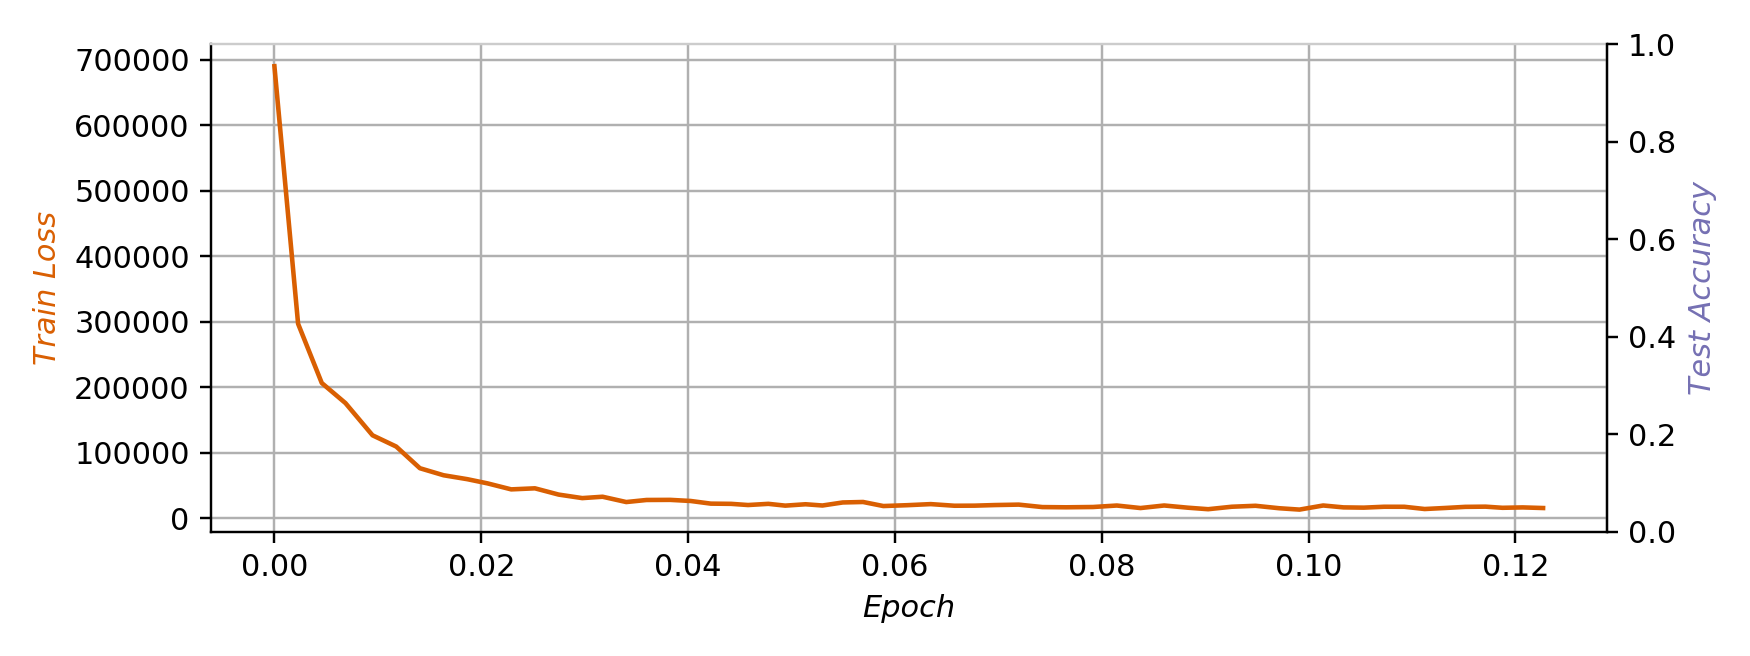

In [3]:
loss_stream = train.create_stream(expr='lambda v:(v.metrics.epochf, v.metrics.batch_loss)', event_name='batch')
loss_plot = tw.Visualizer(loss_stream, vis_type='line', xtitle='Epoch', ytitle='Train Loss')
loss_plot.show()

## Ploting Test Accuracy

Let's overlay test accuracy for each epoch in above graph. We use here `WatcherClient` object for test and then `host` parameter in `Visualizer` constructor to put the graph in exisitng visualizer instead of creating a new one.

In [4]:
test_acc_stream = test.create_stream(expr='lambda d:(d.metrics.epochf, d.metrics.batch_accuracy)', event_name='batch')
test_acc_plot = tw.Visualizer(test_acc_stream, vis_type='line', host=loss_plot, xtitle='Epoch', ytitle='Test Accuracy', yrange=(0,))
test_acc_plot.show()

## Ploting Weight Gradients

Let's do something more interesting. How about plotting average of gradients in each layer? For this we use handly function `grads_abs_mean` that takes model as input and returns gradients averaged for each layer after each batch. We instruct TensorWatch to execute our lambda expression on event named `batch` using `event_name` parameter (other available event is `epoch`). TensorWatch provides [grads_abs_mean](https://github.com/microsoft/tensorwatch/blob/master/tensorwatch/evaler_utils.py#L190) and other utility functions in [evaler_utils](https://github.com/microsoft/tensorwatch/blob/master/tensorwatch/evaler_utils.py) module that you can use in your Python lambda experessions. You can also use any functions from built-in Python packages such as `itertools`. As this computation is expensive we limit frequency to one per second using `throttle=1`. Also notice `history_len=20` parameter for `Visualizer` which instructs to maintain past 20 line plots as history, each one dimmed a little bit as it gets older.

<IPython.core.display.Javascript object>


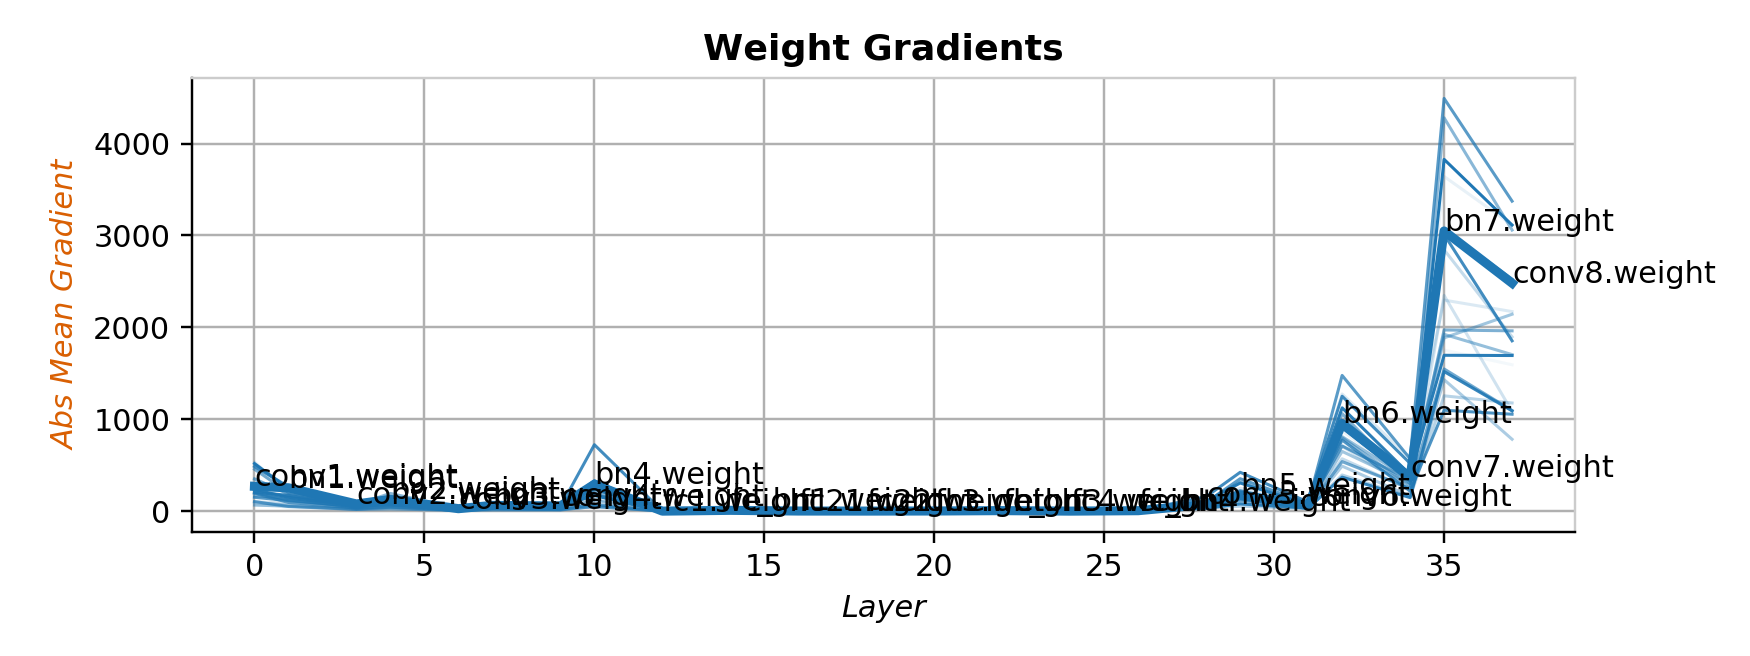

In [5]:
grads_stream = train.create_stream(expr='lambda d: grads_abs_mean(d.model)', event_name='batch', throttle=1)
grads_plot = tw.Visualizer(grads_stream, vis_type='line', title="Weight Gradients", clear_after_each=True, xtitle='Layer', ytitle='Abs Mean Gradient', history_len=20)
grads_plot.show()

## More Real-time On-Demand Plots

Next, we try out several other metrics getting plotted as the training progresses in the script running in the console. Let's try out average of weights per layer, sum of weights per layer, sum of gradients per layer - just for fun. Notice that in each case we are using handy functions available in [evaler_utils](https://github.com/microsoft/tensorwatch/blob/master/tensorwatch/evaler_utils.py#L190). You can of course, write your own custom lambda expressions!

<IPython.core.display.Javascript object>


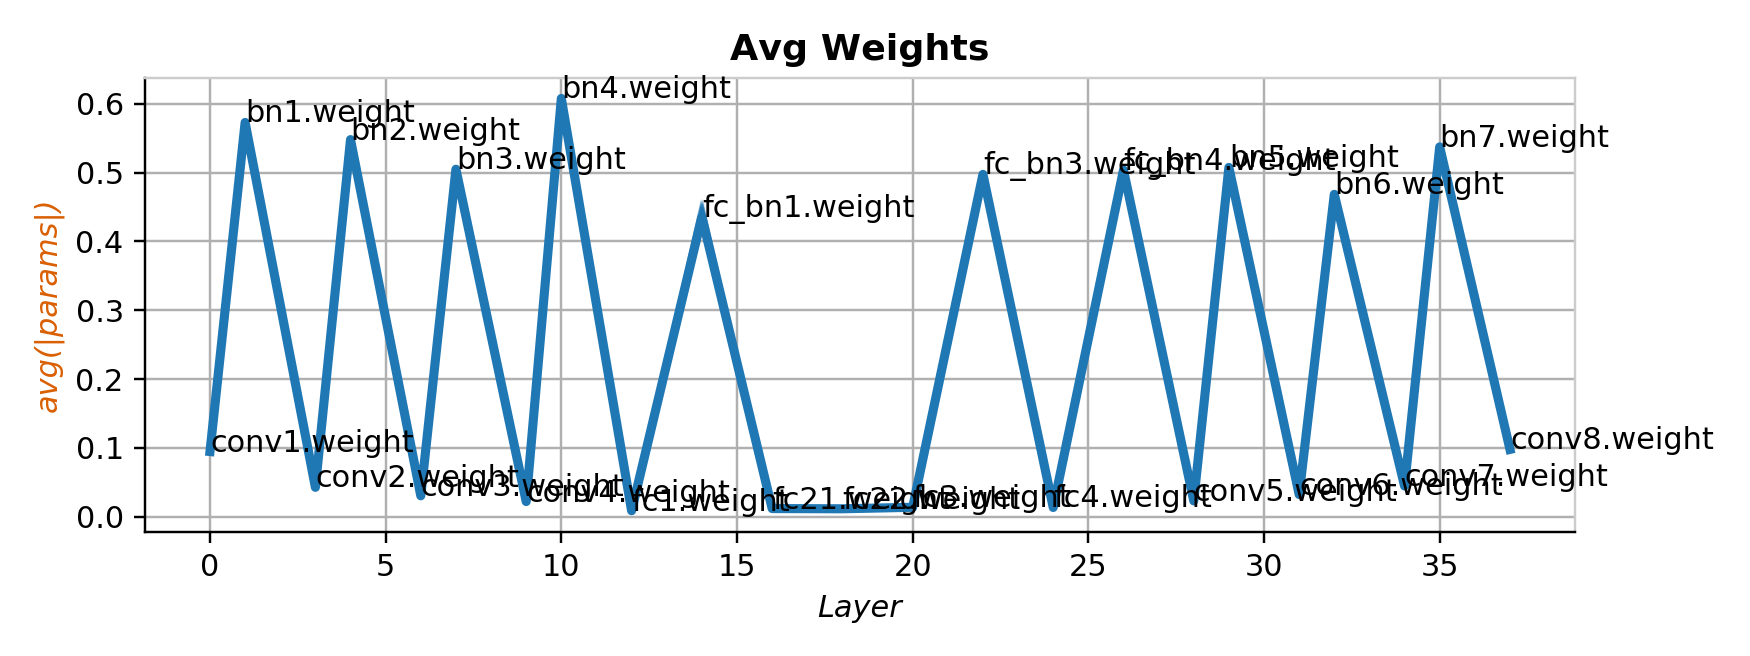

In [6]:
avg_weights_stream = train.create_stream(expr='lambda d: weights_abs_mean(d.model)', event_name='batch', throttle=1)
avg_weights_plot = tw.Visualizer(avg_weights_stream, vis_type='line', title="Avg Weights", clear_after_each=True, xtitle='Layer', ytitle='avg(|params|)', history_len=20)
avg_weights_plot.show()

<IPython.core.display.Javascript object>


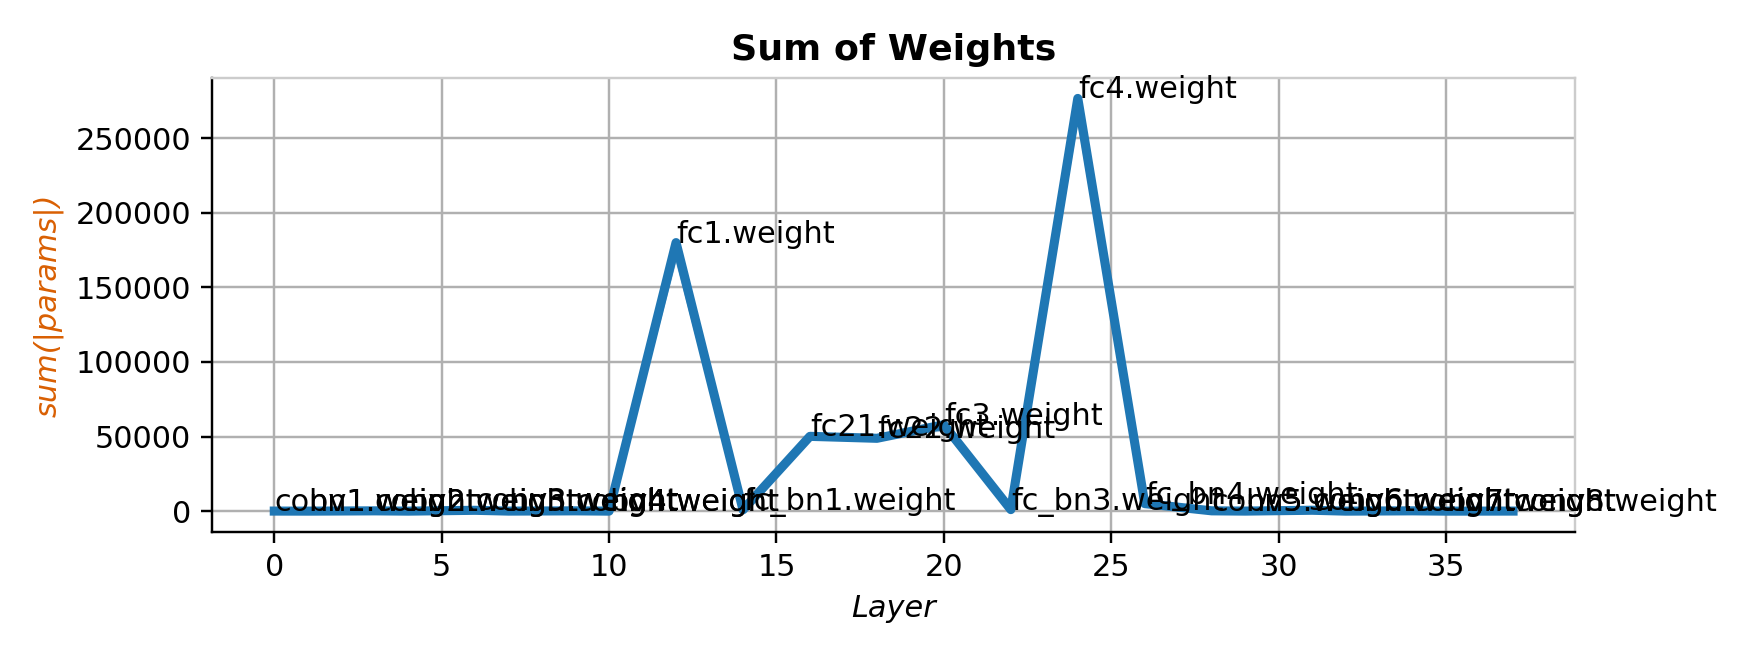

In [7]:
sum_weights_stream = train.create_stream(expr='lambda d: weights_abs_sum(d.model)', event_name='batch', throttle=1)
sum_weights_plot = tw.Visualizer(sum_weights_stream, vis_type='line', title="Sum of Weights", clear_after_each=True,
                                 xtitle='Layer', ytitle='sum(|params|)', history_len=20)
sum_weights_plot.show()

<IPython.core.display.Javascript object>


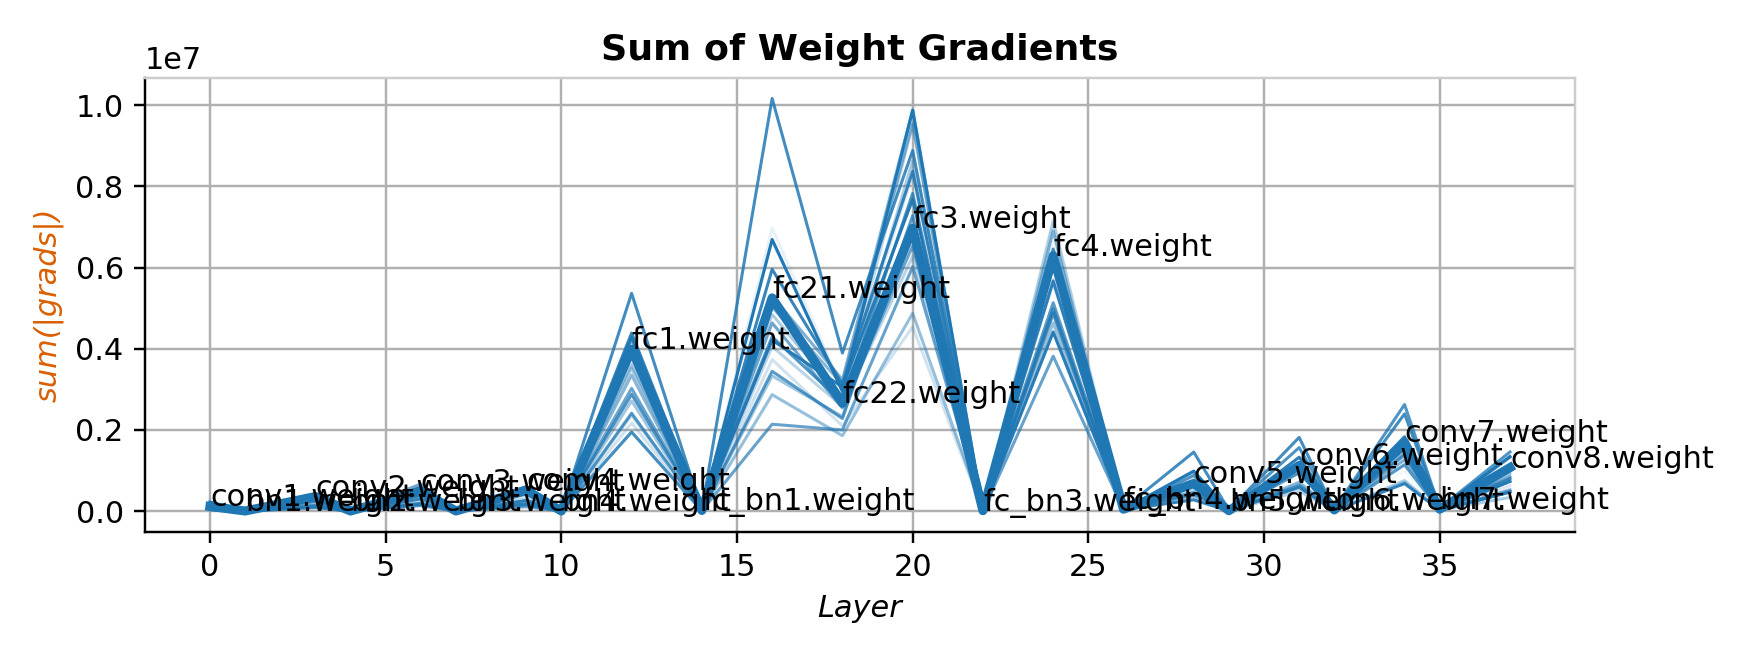

In [8]:
sum_weights_stream = train.create_stream(expr='lambda d: grads_abs_sum(d.model)', event_name='batch', throttle=1)
sum_weights_plot = tw.Visualizer(sum_weights_stream, 
                                 vis_type='line', title="Sum of Weight Gradients", clear_after_each=True,
                                 xtitle='Layer', ytitle='sum(|grads|)', history_len=20)
sum_weights_plot.show()

 ## Plotting Input and Output Images in Real-time
 
Would you like to view some predictions as your training is progressing? How about looking at two randomly sampled (input, output) pairs every second? As we are training autoencoder, the input as well as output are image tensors. As the model gets better over epoch, you would expect output images looking similar to  input images, although they would start out very noisy at first. TensorWatch provides handy [topk_all](https://github.com/microsoft/tensorwatch/blob/master/tensorwatch/evaler_utils.py#L119) function that can help us achieve this. The `topk_all` function accepts lambda that should return the tuple `(losses, (inputs, outputs))` for a given batch. It's `order` function specifies if we should sort `asc`, `dsc` or `rnd` for ascendind, descending or random. The `k=2` parameter instructs to chose top two items. The result is two (input, output) pair of images with loss as its label.

<IPython.core.display.Javascript object>


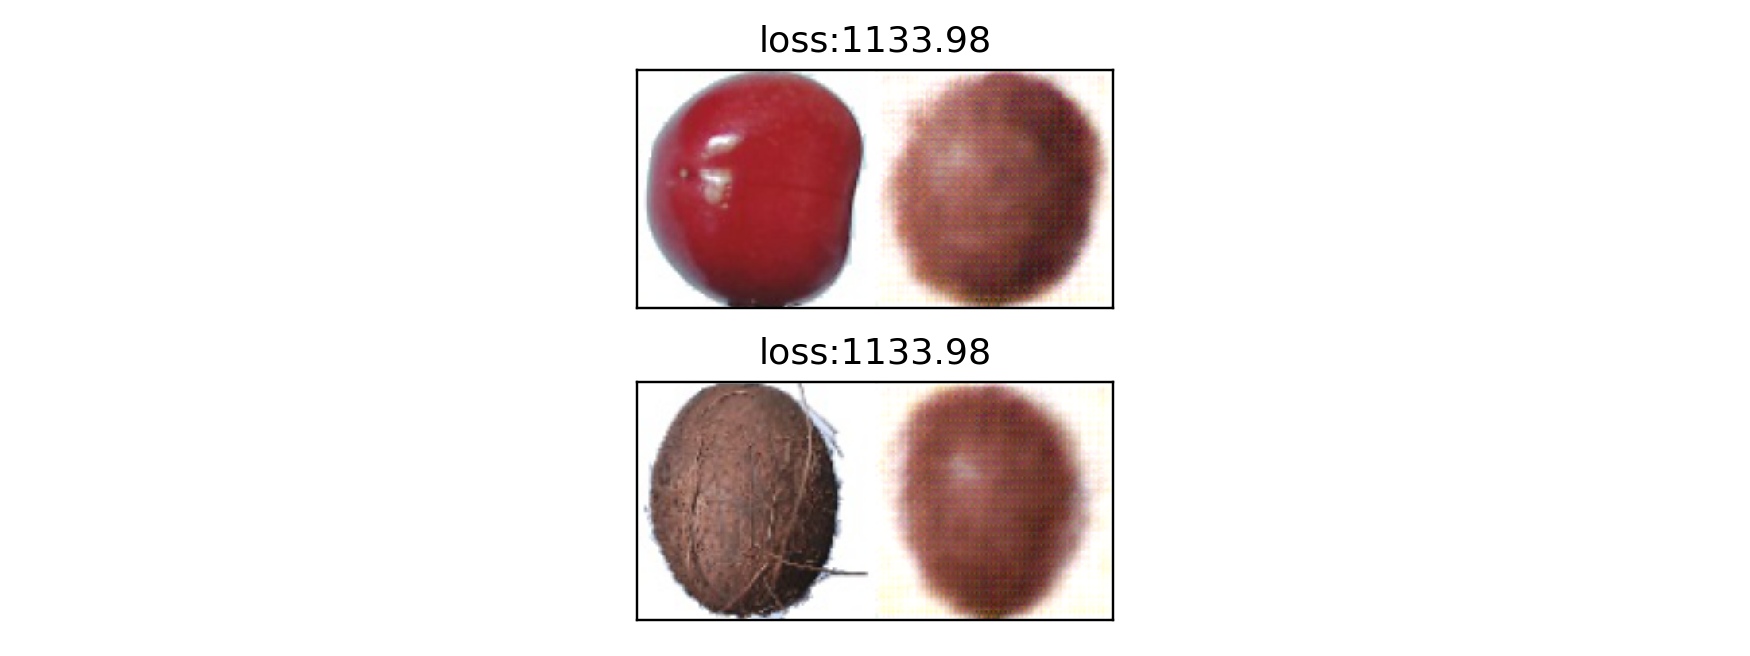

In [9]:
rand_pred = train.create_stream(expr="topk_all(l, \
            batch_vals=lambda b: (b.batch.loss_all, (b.batch.input, b.batch.output)), \
            out_f=image_image_outf, order='rnd', k=2)", event_name='batch', throttle=1)
rand_pred_plot = tw.Visualizer(rand_pred, vis_type='image', title="Random Predictions", img_width=100, img_height=100, viz_img_scale=3, cols=1, rows=2)
rand_pred_plot.show()

## Questions?

Please file a [Github issue](https://github.com/microsoft/tensorwatch/issues/new) and let us know if we can improve this tutorial.